# Profiting from classifiers
### Mini-project
In this project you apply your classification skills for solving a business problem.

Imagine that you are working for a bank. Last year the bank sent a mass direct mailing offer to promote the Personal Equity Plan (PEP). You collected the information about customers and their responses into the dataset [bank_data.csv](https://drive.google.com/file/d/13VEWvirEi-AQwQzZwVZxDSKwym0vAvIk/view?usp=sharing). 

You want to make use of these data to design a new mailing campaign with a higher response rate. The ultimate goal is to spend less for the campaign, but increase the overall profit (number of respondents).

The idea is to build a classification model from historical data, and use this classifier on new customers to predict who is more likely to respond. We can then selectively target only these customers, and not waste the effort on unpromising customer groups.

## Part 1. Building a model

In [1]:
from sklearn.model_selection import cross_val_score

### 1.1. Data exploration and preparation

In [2]:
file_name = "../datasets/bank-data.csv"

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import cross_val_score

# this creates a pandas.DataFrame using the id column for indexing
data = pd.read_csv(file_name, index_col ='id')

In [5]:
data.columns

Index(['age', 'sex', 'region', 'income', 'married', 'children', 'car',
       'save_act', 'current_act', 'mortgage', 'pep'],
      dtype='object')

In [6]:
data.head()

,age,sex,region,income,married,children,car,save_act,current_act,mortgage,pep
id,,,,,,,,,,,
ID12101,48,FEMALE,INNER_CITY,17546.0,NO,1,NO,NO,NO,NO,YES
ID12102,40,MALE,TOWN,30085.1,YES,3,YES,NO,YES,YES,NO
ID12103,51,FEMALE,INNER_CITY,16575.4,YES,0,YES,YES,YES,NO,NO
ID12104,23,FEMALE,TOWN,20375.4,YES,3,NO,NO,YES,NO,NO
ID12105,57,FEMALE,RURAL,50576.3,YES,0,NO,YES,NO,NO,NO


The dataset contains the following variables/attributes for each potential customer: 
- id (String)
- age (int)
- sex {FEMALE,MALE}
- region {INNER_CITY,TOWN,RURAL,SUBURBAN}
- income (int)
- married {YES, NO}
- children (int)
- car {YES, NO}
- save_act - Saving account in our bank {Yes, No}
- current_act - Current account in our bank {YES, NO}
- mortgage {YES, NO}

And the last attribute - pep {YES, NO} is a target attribute: whether a customer responded to our promotion mail and joined a Personal Equity Plan.

To see correlation between attributes and response, we convert all attributes to numeric: .

In [7]:
# First, create a copy of the original data frame - to make a fully numeric dataset
df_num = data.copy()

# we need to replace 'sex', 'region', 'married', 'car', 'save_act', 'current_act', 'mortgage', 'pep'

The boolean values can be replaced with [0,1].

In [8]:
print(df_num['sex'].unique())
print(df_num['married'].unique())
print(df_num['car'].unique())
print(df_num['save_act'].unique())
print(df_num['current_act'].unique())
print(df_num['mortgage'].unique())
print(df_num['pep'].unique())

['FEMALE' 'MALE']
['NO' 'YES']
['NO' 'YES']
['NO' 'YES']
['NO' 'YES']
['NO' 'YES']
['YES' 'NO']


In [9]:
df_num['sex'].replace(['FEMALE', 'MALE'], [0,1], inplace=True)

df_num['married'].replace(['NO', 'YES'], [0,1], inplace=True)
df_num['car'].replace(['NO', 'YES'], [0,1], inplace=True)
df_num['save_act'].replace(['NO', 'YES'], [0,1], inplace=True)
df_num['current_act'].replace(['NO', 'YES'], [0,1], inplace=True)
df_num['mortgage'].replace(['NO', 'YES'], [0,1], inplace=True)
df_num['pep'].replace(['NO', 'YES'], [0,1], inplace=True)

In [10]:
print(df_num['region'].unique())
print(df_num['children'].unique())

['INNER_CITY' 'TOWN' 'RURAL' 'SUBURBAN']
[1 3 0 2]


The 'region' attribute with cardinality 4 should be replaced using [one hot encoding](https://datagy.io/sklearn-one-hot-encode/). Please refresh your knowledge about converting categorical attributes into numerics (binary).

In [11]:
# One-hot encoding a single column - region - using pandas
# use pd.concat to join the new columns with your original dataframe
df_num = pd.concat([df_num,pd.get_dummies(df_num['region'], prefix='region')],axis=1)

# now drop the original 'region' column (you don't need it anymore)
df_num.drop(['region'],axis=1, inplace=True)

For the attribute 'children' there are only 4 distinct values - it is not a truly numeric attribute, it is rather an ordinal attribute. It also does not seem reasonable to assume that the difference between childless families and the families with 1 child is the same as the difference between 1-child and 2-child families. So we should probably treat the number of children as a categorical attribute with cardinality 4.  

In [12]:
df_num['children'].replace([0,1,2,3], ["zero","one", "two", "three"], inplace=True)

In [13]:
df_num = pd.concat([df_num,pd.get_dummies(df_num['children'], prefix='children')],axis=1)

# now drop the original 'country' column (you don't need it anymore)
df_num.drop(['children'],axis=1, inplace=True)

Reordering to place the target variable into the first column.

In [14]:
target = df_num.pop("pep")

df_num.insert(0, target.name, target)

In [15]:
df_num.columns

Index(['pep', 'age', 'sex', 'income', 'married', 'car', 'save_act',
       'current_act', 'mortgage', 'region_INNER_CITY', 'region_RURAL',
       'region_SUBURBAN', 'region_TOWN', 'children_one', 'children_three',
       'children_two', 'children_zero'],
      dtype='object')

<AxesSubplot:>

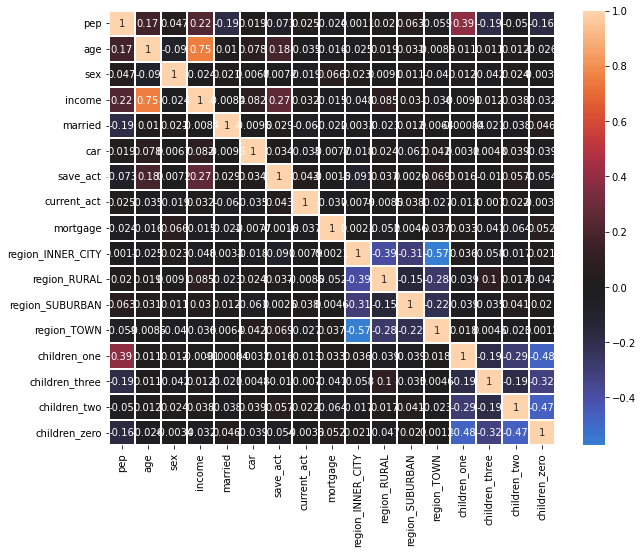

In [16]:
fig, ax = plt.subplots(figsize=(10,8)) 
corr = df_num.corr()
sns.heatmap(corr, center=0, annot=True, linewidths=.1, ax=ax)

## 1.2. Classifiers
We learned about the following classifiers: 
- __Logistic Regression__
- __Support Vector Machines__
- __Decision Trees__
- __k-Nearest Neighbors__
- __Naive Bayes__

We explore each classifier in turn, trying to build the model with the best accuracy for the test set.
We compare classifiers using 10-20 fold cross validation. Do not forget to normalize numeric attributes. After each experiment, use statistical comparison to find out if the current classifier is better than the previous one.

__The best score that I managed to achieve was 89.7. So you should not settle for anything less than 89.5.__

Document all your experiments in the cells below.

### Classifiers that work with exclusively numeric attributes

### K-NN
Use all your knowledge from the K-NN lab to build the K-NN classifier with the best prediction rate. 

In [17]:
# We need to normalize data, thankfully, the code I used in the KNN lab was fairly modular

def normalize(data, print = False, target = "pep"):
    for column in data.columns:
        if (column == target): # This is for something I do at the end
            continue
        max_val = np.max(data[column])
        mean_val = np.mean(data[column])
        sd = np.std(data[column])
        # Divide by max
        data[column] = data[column] / max_val
        
        # We could also center at 0 by subtracting off the mean
        # Or center at 1 by dividing by mean, etc. 

    if print:
        for column in data.columns:
            mean = np.mean(data[column])
            sd = np.std(data[column])
            print(column)
            print(mean)
            print(sd)
        
    return data

In [18]:
df_norm = normalize(df_num.copy())

# We'll reweight according the correlations.
# Things with a negative correlation, I weight less
# Things with a positive, I weight more

df_norm['age'] = df_norm['age']*0.75
df_norm['income'] = df_norm['income']*0.75
df_norm['children_one'] = df_norm['children_one']*0.5
df_norm['married'] = df_norm['married']*1.2
df_norm['children_two'] = df_norm['children_two']*1.1
from sklearn.model_selection import train_test_split

# make data
X = df_norm.drop(columns=['pep'])
Y = df_norm['pep'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [19]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=18)

knn.fit(X_train, Y_train)
print("Train score:", knn.score(X_train, Y_train))
print("Test score:", knn.score(X_test, Y_test))

Train score: 0.7958333333333333
Test score: 0.7


In [20]:
from sklearn.model_selection import GridSearchCV

#create new a knn model
new_knn = KNeighborsClassifier(weights='distance')

#create a dictionary of all values we want to test for n_neighbors
grid_dictionary = {'n_neighbors': np.arange(1,35)}

grid_search = GridSearchCV(new_knn, grid_dictionary, cv = 20)


#fit model to data
grid_search.fit(X, Y)
print(grid_search.best_params_)

{'n_neighbors': 17}


In [21]:
# Let's use CV now:
cv_knn = KNeighborsClassifier(n_neighbors=34, weights='distance')
scores = cross_val_score(cv_knn, X, Y,cv = 20)

In [22]:
np.mean(scores)

0.75

### Logistic Regression
Try Logistic Regression. Try different Expectation Maximization algorithms. Maybe some variations of regularization? 

Is your Log Regr score better than the K-NN score? Is it significantly better? If the scores do not differ significantly, you may continue with any of them. Otherwise, continue with the better classifier.

In [35]:
# make data clean
df_lr = normalize(df_num.copy())

df_lr['age'] = df_lr['age']*0.75
df_lr['income'] = df_lr['income']*0.75
df_lr['children_one'] = df_lr['children_one']*0.5
df_lr['married'] = df_lr['married']*1.1
df_lr['children_two'] = df_lr['children_two']*1

lrX = df_lr.drop(columns=['pep'])
lrY = df_lr['pep'].values
lrX_train, lrX_test, lrY_train, lrY_test = train_test_split(lrX, lrY, test_size=0.2)

In [37]:
from sklearn.linear_model import LogisticRegression

best_i = 0
best_score = 0
cur_score = 0
for i in range(20):    
    lr = LogisticRegression(C = (0.2 + i / 10))
    
    
    cur_score  = np.mean(cross_val_score(lr, lrX, lrY,cv = 10))
    if cur_score > best_score:
        best_i = i
        best_score = cur_score
print(best_i)
best_score

1


0.7433333333333334

In [38]:
lr = LogisticRegression(C = 0.3)
lr.fit(lrX_train, lrY_train)
lr.score(lrX_test, lrY_test)

0.75

So we start with a score of 0.792, let's see if we can raise that at all. 

In [198]:
lr_new = LogisticRegression(solver = 'newton-cg')
lr_new.fit(lrX_train, lrY_train)
lr_new.score(lrX_test, lrY_test)

0.7666666666666667

Well that did not help. Maybe we can change the penalty?

In [199]:
lr_e = LogisticRegression(dual = True, penalty = 'l2', solver = 'liblinear')


lr_e.fit(lrX_train, lrY_train)
lr_e.score(lrX_test, lrY_test)

0.7666666666666667

In [200]:
from sklearn.linear_model import LogisticRegressionCV

lrCV = LogisticRegressionCV(cv = 10)

lrCV.fit(lrX_train, lrY_train)
lrCV.score(lrX_test, lrY_test)

0.7416666666666667

Maybe we can mess with tolerances?

In [201]:
lr_tol = LogisticRegression(tol = 0.00005, C = .78, max_iter = 2000) 
lr_tol.fit(lrX_train, lrY_train)
lr_tol.score(lrX_test, lrY_test)

0.775

In [202]:
lr_e = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.75)


lr_e.fit(X_train, Y_train)
lr_e.score(X_test, Y_test)

/Users/isaacweissman/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


0.7083333333333334

In [203]:
from sklearn.linear_model import Ridge, Lasso
rr = Ridge(alpha=1) 
rr.fit(lrX_train, lrY_train)
print('rr', rr.score(lrX_test, lrY_test))

lasso = Lasso(alpha=1, max_iter=10e5)
lasso.fit(lrX_train,lrY_train)
print('lasso', lasso.score(lrX_test, lrY_test))

rr 0.26669556668354866
lasso -0.020905671296296058


We never managed to improve out LR score beyond .7916. We got 0.8 in some samples, but that went away with resampling. Not sure what to try now, the two classifiers seem pretty similar so far.

### Support Vector Machines
Try to improve classification with SVM. Compare the scores statistically. COntinue with a better classifier.

In [39]:
from sklearn.svm import SVC 

svm = SVC(kernel = 'poly')
svm.fit(lrX_train, lrY_train)
svm.score(lrX_test, lrY_test)

0.8333333333333334

In [40]:
len(Y_test)

120

Oho! Already we have a better result! Unclear if it is significantly better since I didn't run many samples (meaning it is unclear what the standard deviation would be), to get around this, I did a two sample test of proportions instead of the normal t-test. 

In testing if our new value is better (strictly greater than our previous result), my Stata tells me that our SVM is NOT noticeably better with our 120 total observations (I used 120 for the testing set size). We have a p-value of 0.11, which is just shy of significance. Can we maybe improve our SVC at all?

In [41]:
svm = SVC()
svm.fit(lrX_train, lrY_train)
svm.score(lrX_test, lrY_test)

0.875

Switching to the default kernel function, we raise our score a little bit. This actually ticks us over into significance at the 10% level, which is nice. But, as we asked all too often in Algorithms, can we do better?

In [42]:
best_t = ''
best_score = 0
cur_score = 0
for typ in ['linear', 'poly', 'rbf', 'sigmoid']:
    t_svm = SVC(kernel = typ)
    scores = cross_val_score(t_svm, lrX, lrY,cv = 20)
    cur_score = np.mean(scores)
    if cur_score > best_score:
        best_score = cur_score
        best_t = typ
        
print(best_score, best_t)

0.8233333333333335 poly


Maybe we cant...

In [43]:
# Let's use CV now:
cv_svm = SVC(kernel = 'poly')
scores = cross_val_score(cv_svm, lrX, lrY,cv = 20)
np.mean(scores)

0.8233333333333335

### It is pretty clear that SVM might be our best bet. So let's experiment with our weights to try to maximize our scores


In [77]:
# make data clean
df_svm = normalize(df_num.copy())

df_svm['age'] = df_svm['age']*1
df_svm['income'] = df_svm['income']*1
df_svm['children_one'] = df_svm['children_one']*1
df_svm['married'] = df_svm['married']*1
df_svm['children_two'] = df_svm['children_two']*1

svmX = df_svm.drop(columns=['pep'])
svmY = df_svm['pep'].values
svmX_train, svmX_test, svmY_train, svmY_test = train_test_split(svmX, svmY, test_size=0.2)

In [82]:
# No weights, un-normalized: 
# (we remove the linear kernel, it would take too long)
df_svm = df_num.copy()
svmX = df_svm.drop(columns=['pep'])
svmY = df_svm['pep'].values
svmX_train, svmX_test, svmY_train, svmY_test = train_test_split(svmX, svmY, test_size=0.2)
best_t = ''
best_score = 0
cur_score = 0
for typ in ['poly', 'rbf', 'sigmoid']:
    t_svm = SVC(kernel = typ)
    scores = cross_val_score(t_svm, svmX, svmY,cv = 20)
    cur_score = np.mean(scores)
    if cur_score > best_score:
        best_score = cur_score
        best_t = typ
        
print(best_score, best_t)

0.5816666666666667 poly


In [200]:
# Normalized: Unweighted

df_svm = normalize(df_num.copy())

df_svm['age'] = df_svm['age']*1
df_svm['income'] = df_svm['income']*1
df_svm['children_one'] = df_svm['children_one']*1
df_svm['married'] = df_svm['married']*1
df_svm['children_two'] = df_svm['children_two']*1

svmX = df_svm.drop(columns=['pep'])
svmY = df_svm['pep'].values
svmX_train, svmX_test, svmY_train, svmY_test = train_test_split(svmX, svmY, test_size=0.2)

best_t = ''
best_score = 0
cur_score = 0
for typ in ['linear','poly', 'rbf', 'sigmoid']:
    t_svm = SVC(kernel = typ)
    scores = cross_val_score(t_svm, svmX, svmY,cv = 20)
    cur_score = np.mean(scores)
    if cur_score > best_score:
        best_score = cur_score
        best_t = typ
        
print(best_score, best_t)

0.8400000000000002 poly


Pretty good! A score of 0.84 is definitely a good start

In [119]:
# Changing weights?

df_svm = normalize(df_num.copy())

df_svm['age'] = df_svm['age']*1.5
df_svm['income'] = df_svm['income']*2
df_svm['children_one'] = df_svm['children_one']*2.5
df_svm['married'] = df_svm['married']*1
df_svm['children_two'] = df_svm['children_two']*1

svmX = df_svm.drop(columns=['pep'])
svmY = df_svm['pep'].values
svmX_train, svmX_test, svmY_train, svmY_test = train_test_split(svmX, svmY, test_size=0.2)

best_t = ''
best_score = 0
cur_score = 0
deg = 3
for typ in ['linear','poly', 'rbf', 'sigmoid']:
        for deg in range(2, 6):
            t_svm = SVC(kernel = typ, degree = deg)
            scores = cross_val_score(t_svm, svmX, svmY,cv = 20)
            cur_score = np.mean(scores)
            if cur_score > best_score:
                best_score = cur_score
                if typ == 'poly':
                    best_t = typ+str(deg)
                else:
                    best_t = typ
            if typ != 'poly':
                break
        
print(best_score, best_t)

0.8533333333333333 poly3


Ok! Now we're getting somewhere. By increasing certain values, we can raise our svm scores

In [251]:
# Changing weights?
df_svm = normalize(df_num.copy())

df_svm['age'] = df_svm['age']*1.45
df_svm['income'] = df_svm['income']*2
df_svm['children_one'] = df_svm['children_one']*2.5
df_svm['children_two'] = df_svm['children_two']*0.95
df_svm['married'] = df_svm['married']*0.975

svmX = df_svm.drop(columns=['pep'])
svmY = df_svm['pep'].values
svmX_train, svmX_test, svmY_train, svmY_test = train_test_split(svmX, svmY, test_size=0.2)

best_t = ''
best_score = 0
cur_score = 0
deg = 3
for typ in ['linear','poly', 'rbf', 'sigmoid']:
        for deg in range(1, 7):
            t_svm = SVC(kernel = typ, degree = deg, tol=0.001)
            scores = cross_val_score(t_svm, svmX, svmY,cv = 20)
            cur_score = np.mean(scores)
            if cur_score > best_score:
                best_score = cur_score
                if typ == 'poly':
                    best_t = typ+str(deg)
                else:
                    best_t = typ
            if typ != 'poly':
                break

print(best_score, best_t)

0.8566666666666667 poly3


We can tune in a little bit more, I wrote a for loop that tests all values in a cloud of the points around the previous weight, and ended up with this as my maximum score. 

We're now at 85.67 score. 

Can we do better?

In [188]:
    # Changing our regularization parameter:
for c_val in range(50, 250, 10):
        df_svm = normalize(df_num.copy())

        df_svm['age'] = df_svm['age']*1.45
        df_svm['income'] = df_svm['income']*2
        df_svm['children_one'] = df_svm['children_one']*2.5
        df_svm['children_two'] = df_svm['children_two']*0.95
        # I actually always meant to use children three instead of 2
        df_svm['children_three'] = df_svm['children_three']*0.975
        df_svm['married'] = df_svm['married']*0.975

        svmX = df_svm.drop(columns=['pep'])
        svmY = df_svm['pep'].values
        svmX_train, svmX_test, svmY_train, svmY_test = train_test_split(svmX, svmY, test_size=0.2)

        best_t = ''
        best_score = 0
        cur_score = 0
        deg = 3
        for typ in ['linear','poly', 'rbf', 'sigmoid']:
                for deg in range(2, 6):
                    t_svm = SVC(kernel = typ, degree = deg, C = c_val/100)
                    scores = cross_val_score(t_svm, svmX, svmY,cv = 20)
                    cur_score = np.mean(scores)
                    if cur_score > best_score:
                        best_score = cur_score
                        if typ == 'poly':
                            best_t = typ+str(deg)
                        else:
                            best_t = typ
                    if typ != 'poly':
                        break

        print(best_score, best_t, c_val/100)

0.8433333333333334 poly4 0.5
0.8466666666666667 poly4 0.6
0.8483333333333334 poly4 0.7
0.8466666666666667 poly3 0.8
0.8450000000000001 poly3 0.9
0.8566666666666667 poly3 1.0
0.8550000000000001 poly3 1.1
0.8516666666666668 poly3 1.2
0.8500000000000002 rbf 1.3
0.8516666666666668 rbf 1.4
0.8516666666666668 rbf 1.5
0.8533333333333335 rbf 1.6
0.8533333333333335 rbf 1.7
0.8533333333333335 rbf 1.8
0.8550000000000002 rbf 1.9
0.8583333333333336 rbf 2.0
0.8583333333333336 rbf 2.1
0.8566666666666668 rbf 2.2
0.8583333333333334 rbf 2.3
0.8600000000000001 rbf 2.4


We can get up to 86%!

In [190]:
    # Changing our regularization parameter AGAIN!:
for c_val in range(300, 410, 5):
        df_svm = normalize(df_num.copy())

        df_svm['age'] = df_svm['age']*1.45
        df_svm['income'] = df_svm['income']*2
        df_svm['children_one'] = df_svm['children_one']*2.5
        df_svm['children_two'] = df_svm['children_two']*0.95
        # I actually always meant to use children three instead of 2
        df_svm['children_three'] = df_svm['children_three']*0.975
        df_svm['married'] = df_svm['married']*0.975

        svmX = df_svm.drop(columns=['pep'])
        svmY = df_svm['pep'].values
        svmX_train, svmX_test, svmY_train, svmY_test = train_test_split(svmX, svmY, test_size=0.2)

        best_t = ''
        best_score = 0
        cur_score = 0
        deg = 3
        for typ in ['linear','poly', 'rbf', 'sigmoid']:
                for deg in range(2, 6):
                    t_svm = SVC(kernel = typ, degree = deg, C = c_val/100)
                    scores = cross_val_score(t_svm, svmX, svmY,cv = 20)
                    cur_score = np.mean(scores)
                    if cur_score > best_score:
                        best_score = cur_score
                        if typ == 'poly':
                            best_t = typ+str(deg)
                        else:
                            best_t = typ
                    if typ != 'poly':
                        break

        print(best_score, best_t, c_val/100)

0.8683333333333334 rbf 3.0
0.8683333333333334 rbf 3.05
0.8666666666666668 rbf 3.1
0.865 rbf 3.15
0.8666666666666668 rbf 3.2
0.8666666666666668 rbf 3.25
0.865 rbf 3.3
0.865 rbf 3.35
0.865 rbf 3.4
0.865 rbf 3.45
0.865 rbf 3.5
0.8666666666666666 rbf 3.55
0.865 rbf 3.6
0.865 rbf 3.65
0.865 rbf 3.7
0.865 rbf 3.75
0.865 rbf 3.8
0.865 rbf 3.85
0.865 rbf 3.9
0.865 rbf 3.95
0.865 rbf 4.0
0.865 rbf 4.05


Now let's try using the RBF with a regularization of 3.0 on different weights:
Our current best is 86.83

In [196]:
df_svm = normalize(df_num.copy())

df_svm['age'] = df_svm['age']*1.45
df_svm['income'] = df_svm['income']*2
df_svm['children_one'] = df_svm['children_one']*2.5
df_svm['children_two'] = df_svm['children_two']*0.95
# I actually always meant to use children three instead of 2
df_svm['children_three'] = df_svm['children_three']*1
df_svm['married'] = df_svm['married']*0.975

svmX = df_svm.drop(columns=['pep'])
svmY = df_svm['pep'].values
svmX_train, svmX_test, svmY_train, svmY_test = train_test_split(svmX, svmY, test_size=0.2)

best_t = ''
best_score = 0
cur_score = 0
deg = 3
for typ in ['linear','poly', 'rbf', 'sigmoid']:
        for deg in range(2, 6):
            t_svm = SVC(kernel = typ, degree = deg, C = 3, tol )
            scores = cross_val_score(t_svm, svmX, svmY,cv = 20)
            cur_score = np.mean(scores)
            if cur_score > best_score:
                best_score = cur_score
                if typ == 'poly':
                    best_t = typ+str(deg)
                else:
                    best_t = typ
            if typ != 'poly':
                break

print(best_score, best_t)

0.8683333333333334 rbf


### Classifiers that work with both numeric and categorical attributes
### Naive Bayes
We can use Naive Bayes classifier on the original dataset without replacing categorical values with numeric ones. 
Think which parameters still need to be adjusted. Maybe try binning income and age into categorical bins. Try Naive Bayes classifier. Adjust parameters. Maybe you can use a ROC curve to set a different classification threshold? Select the best classifer so far.

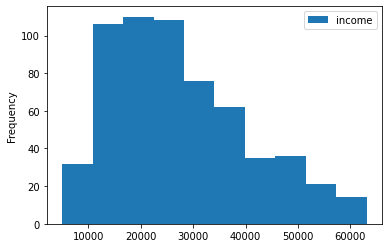

In [238]:
# Let's bucket everything now, and re-import data:


bayes = data.copy() 
bayes.plot.hist(y = 'income')
# Let's have 4 categories, <17000, 17000-23000, 23000-30000, >30,000
# Age to bins
bins = [17000, 23000, 29000, np.inf]
names = [0, 1, 2]
bayes['income'] = pd.cut(bayes['income'], bins, labels=names)

bins = [15, 30, 45, 60, np.inf]
names = [0, 1, 2, 3]

bayes['age'] = pd.cut(bayes['age'], bins, labels=names)

In [243]:
bayes['sex'].replace(['FEMALE', 'MALE'], [0,1], inplace=True)

bayes['married'].replace(['NO', 'YES'], [0,1], inplace=True)
bayes['car'].replace(['NO', 'YES'], [0,1], inplace=True)
bayes['save_act'].replace(['NO', 'YES'], [0,1], inplace=True)
bayes['current_act'].replace(['NO', 'YES'], [0,1], inplace=True)
bayes['mortgage'].replace(['NO', 'YES'], [0,1], inplace=True)
bayes['pep'].replace(['NO', 'YES'], [0,1], inplace=True)
bayes['region'].replace(['INNER_CITY', 'TOWN', 'RURAL', 'SUBURBAN'], [0, 1, 2, 3], inplace = True)

In [244]:
# make data clean
bayes_X = bayes.drop(columns=['pep'])
bayes_Y = bayes['pep'].values
bayes_X_train, bayes_X_test, bayes_Y_train, bayes_Y_test = train_test_split(bayes_X, bayes_Y, test_size=0.2)

In [247]:
from sklearn.naive_bayes import CategoricalNB

naive = CategoricalNB()
cv_score = np.mean(cross_val_score(naive, bayes_X, bayes_Y,cv = 20))
print(cv_score)
naive.fit(bayes_X_train, bayes_Y_train)
naive.score(bayes_X_test, bayes_Y_test)

0.6949999999999998


0.7416666666666667

Uh oh, this isn't very good...

I did a few modifications, and every move made things worse.


### Decision tree
Unfortunately the sklearn implementation of the decision tree does not take the full advantage of the decision tree power. The sklearn implementation does not work with categorical attributes. You can of course use it on the numeric dataset. The reesults however will be discouraging. Nevertheless try it, play with parameters.

You have of course the option of using our custom Decision tree code. You can look at the decision tree produced by our custom code to determine which attributes are most important for classification. You can then reweight them, or even get rid of some attributes and repeat your experiments with all the five classifiers. As a matter of fact, using only a subset of attributes identified this way I was able to improve the classification score.

You can also use our custom decision tree as a final classifier, but it requires additional coding to produce probability of class prediction and to evaluate the performance. So do it only if you have time (and desire).

In [248]:
from sklearn.tree import DecisionTreeClassifier

# Decision Trees with numeric attributes are scale independent, so we don't need to scale at all. 

df_dt = df_num.copy()
dec_tree = DecisionTreeClassifier()

df_dt_X = df_dt.drop(columns=['pep'])
df_dt_Y = df_dt['pep'].values
np.mean(cross_val_score(dec_tree, bayes_X, bayes_Y,cv = 20))

0.8116666666666668

This isn't actually as bad as I was expecting, this is a decent score!

### SELECT FINAL CLASSIFIER
After all the experiments, select the classifier with the best accuracy (you used cross-validation).

Now break your dataset into two parts (using 1:2 ratio) and use one part for testing and 2 parts for building the model.

After you buid the final model, make the predictions for each instance in the test set, and record these predictions as _PROBABILITIES_ of belonging to the 'pep' class. __Store these predictions in a separate csv file. This is the input for Part II of this mini-project.__

In [420]:
df_svm = normalize(df_num.copy())

df_svm['age'] = df_svm['age']*1.45
df_svm['income'] = df_svm['income']*2
df_svm['children_one'] = df_svm['children_one']*2.5
df_svm['children_two'] = df_svm['children_two']*0.95
# I actually always meant to use children three instead of 2
df_svm['children_three'] = df_svm['children_three']*1
df_svm['married'] = df_svm['married']*0.975

svmX = df_svm.drop(columns=['pep'])
svmY = df_svm['pep'].values
svmX_train, svmX_test, svmY_train, svmY_test = train_test_split(svmX, svmY, test_size=0.3333333333333333333333)

t_svm = SVC(kernel = 'rbf', C = 3, probability = True)
t_svm.fit(svmX_train, svmY_train)


SVC(C=3, probability=True)

In [421]:
probs = t_svm.predict_proba(svmX_test)

In [422]:
prob_df = pd.DataFrame(probs, columns = ['noPep', 'yesPep'])
prob_df['pred_class'] = np.where(prob_df['yesPep'] >= 0.5, 1, 0)
prob_df['true_class'] = svmY_test

In [423]:
t_svm.predict(svmX_test)

array([0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1], dtype=int64)

In [424]:
prob_df.to_csv("probs.csv", index = False)

## Part II. Business pitch

### Lift chart
The result of the previous part is the table of predicted class labels for each instance in the test set. The predictions are expressed in terms of probability of being classified as 'pep' - that is, probability that the respondents buy the equity plan.

Our main business proposal is to take a new dataset of potential subscribers, predict their response using our best model, and use only top-ranked customers for the next promotion. 

Here we want to persuade the bank that targeting selected customers will improve the campaign efficiency: that we can achieve a much better response rate.

First, we sort the test dataset by the predicted class - from Yes to No, and then by probability (from highest to the lowest for Yes and from lowest to highest for No). Keep the sorted file separately from the original test set - we need both datasets.

Next, we count the number of successfully predicted subscribers, adding for each row in the sorted dataset the cumulative number of customers which responded to the offer. Now, for each number of letter sent we plot the total number of positive responses (see image below for an example). 

<img src = "images/counts.png" text-align="center" width=50%>

What can we learn from this chart? The logic is that if we send 10 letters - the success rate of these letters will be high, because 9 out of 10 would reply. If we send 100 letters the success rate would be 69%. However with 100 letters this means 69 new subscribers, and with 10 - only 9. We want to know what is the optimal number of letters to be sent to maximize the profit.

<img src = "images/LiftChart.png" text-align="center" width=50%>

For business audience we visualize the results using lift charts, where on the X axis is a number of letters sent, and on the Y axis is the proportion of positive responses for the random mailing and for the mailing which would use the top-ranked customers first. Lift (in the business world) is the ratio of the expected ‘Yes’ responses using the top of predicted list to the number of ‘Yes’ responses from the same number of randomly selected customers. Lift measures the change in the concentration of a target class when the model is applied to the future dataset. Note that if we would send all 180 letters we would have 83 positive responses (46% total success) in both cases.

Analyzing this chart, we can see that by sending mails to only 73/180 = 40% of the customers from the top of the ranked list, we should be able to cover 82% of potential responders. 

Note that we cannot ever cover all 100% of responsive customers, unless we send letters to everybody - our model does not give 100% correct answers.

__Create the Lift chart from your results, and write a couple of sentences pitching the use of a classifier.__

In [425]:
# We can re_use the probs_df from before
prob_df

,noPep,yesPep,pred_class,true_class
0,0.840042,0.159958,0,0
1,0.550952,0.449048,0,0
2,0.821567,0.178433,0,1
3,0.064190,0.935810,1,1
4,0.843162,0.156838,0,0
...,...,...,...,...
195,0.971127,0.028873,0,0
196,0.822177,0.177823,0,0
197,0.933982,0.066018,0,0
198,0.162801,0.837199,1,1


In [426]:
sorted_df = prob_df.sort_values(by=['pred_class', 'yesPep'], ascending = False)
sorted_df

,noPep,yesPep,pred_class,true_class
166,0.007301,0.992699,1,1
120,0.007796,0.992204,1,1
30,0.008449,0.991551,1,1
125,0.010026,0.989974,1,1
65,0.014385,0.985615,1,1
...,...,...,...,...
161,0.966487,0.033513,0,0
20,0.967862,0.032138,0,1
195,0.971127,0.028873,0,0
81,0.972906,0.027094,0,1


In [427]:
sum_df = sorted_df[np.logical_and(sorted_df['pred_class'] == 1, sorted_df['true_class'] == 1)]['pred_class'].cumsum()
sum_df = pd.DataFrame(sum_df)
sum_df = sum_df.rename(columns={"pred_class": "cumsum"})
sum_df


,cumsum
166,1
120,2
30,3
125,4
65,5
...,...
77,73
147,74
168,75
64,76


In [428]:
sorted_df = sorted_df.join(sum_df)

In [429]:
last_val = 0
ret_arr = []
for val in sorted_df['cumsum'].values:
    if pd.isna(val):
        ret_arr.append(last_val)
    else:
        ret_arr.append(val)
        last_val = val
sorted_df['cumsum'] = ret_arr

In [430]:
sorted_df['cumsum'].astype(np.int64)

166     1
120     2
30      3
125     4
65      5
       ..
161    77
20     77
195    77
81     77
35     77
Name: cumsum, Length: 200, dtype: int64

In [431]:
# We're now

In [432]:
sorted_df['true_cumsum'] = prob_df['true_class'].cumsum().values

In [433]:
sorted_df['letters_sent'] = 1
sorted_df['letters_sent'] = sorted_df['letters_sent'].cumsum().values

In [434]:
# Add hues:

sorted_df['ML_model'] = ""
sorted_df['Random'] = 3

<AxesSubplot:xlabel='Positive Responses', ylabel='Letters Sent'>

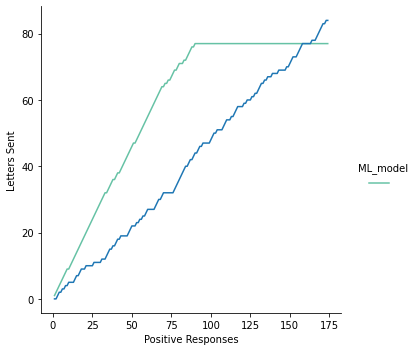

In [435]:
p = sns.relplot(
    data=sorted_df[sorted_df['letters_sent'] < 175],
    x='letters_sent', y="cumsum", 
    kind = 'line',palette= "Set2", hue = "ML_model"
)
(p.set_axis_labels("Positive Responses", "Letters Sent")
  .set_titles("ML Model vs. Random for Letter Sending")
  .tight_layout(w_pad=0))

sns.lineplot(x="letters_sent", y="true_cumsum",
             data=sorted_df[sorted_df['letters_sent'] < 175], legend = False)

<AxesSubplot:xlabel='Positive Responses', ylabel='Letters Sent'>

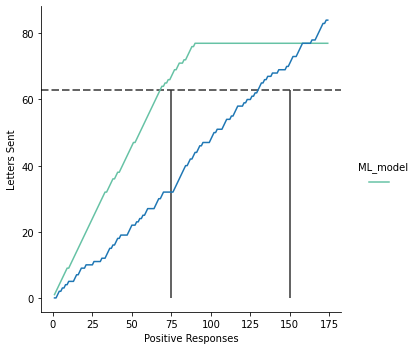

In [436]:
p = sns.relplot(
    data=sorted_df[sorted_df['letters_sent'] < 175],
    x='letters_sent', y="cumsum", 
    kind = 'line',palette= "Set2", hue = "ML_model"
)
(p.map(plt.axhline, y=63, color=".2", dashes=(5, 2), zorder=0)
    .map(plt.vlines, x=[75,150], ymin = 0, ymax = 63, color=".2")
    .set_axis_labels("Positive Responses", "Letters Sent")
    .set_titles("ML Model vs. Random for Letter Sending")
)
sns.lineplot(x="letters_sent", y="true_cumsum",
             data=sorted_df[sorted_df['letters_sent'] < 175], legend = False)

## What Do we See?

We can get roughly equal performance by sending half of the letters! While sending randomly to everyone will eventually result in more total yeses, you have to at least double the number of letters sent before seeing additional returns. 

### Cost-benefit analysis

Just showing the lift chart might be not enough to persuade bank to apply your classifier. We need to estimate potential revenue.

How to choose the optimal number of letters to send? This depends on the:
- Cost of each mail: for example, let it be 4
- Benefit from each accepted PEP: let it be 15

These unrealistic numbers were chosen because of the very small size of the validation dataset – to demonstrate the concept of maximum profit. In real life, the cost of mailing is several cents, and the benefit is hundreds and thousands dollars, but the real datasets of mailings contain millions of records.

Then for each row in the sorted table:
- We multiply each count of total sent by 4 - the cost of sending
- We multiply each positive count by 15 - expected benefit (not everything that we predicted as positive was actually positive, some of our predictions were wrong).
- We subtract the cost from the benefit. 
This produces an expected revenue for a given number of letters sent.

In my results sending about 71-73 letters gave the maximum profit of ~ 700 dollars. This profit cannot be achieved by random mailing, this is the profit to our company that we created using machine learning. BTW, what would be the total profit if we sent just 73 letters from the random dataset?

__What are your results? Did you manage to generate more profit?__ Briefly discuss your results and what did you learn from this project.


In [442]:
cost = 4
ben = 15

sorted_df['cost'] = sorted_df['letters_sent']*cost
sorted_df['return'] = sorted_df['cumsum']*ben
sorted_df['random_return'] = sorted_df['true_cumsum']*ben
sorted_df['profit'] = sorted_df['return'] - sorted_df['cost']
sorted_df['random_profit'] = sorted_df['random_return'] - sorted_df['cost']

In [443]:
sorted_df['random_profit'][73] 

309

In [447]:
max_v = np.max(sorted_df['profit']) 
max_v

795.0

In [448]:
sorted_df[sorted_df['profit'] == max_v]

,noPep,yesPep,pred_class,true_class,cumsum,true_cumsum,letters_sent,ML_model,Random,cost,return,random_return,profit,random_profit
58,0.447341,0.552659,1,1,77.0,44,90,,3,360,1155.0,660,795.0,300


In [449]:
sorted_df['random_profit'][58] 

300

We reach our maximum profit at sending just 58 letters in total, but we generate a total of 795$ in profit, which is about double the amount of profit as sending letters randomly--and far more than random every generates.

(Sending 73 letters randomly has a profit of 309$). 

So, despite haveing a model that predicted slightly less correctly than 89.5, we still made more than 700$! A possible explanation for this could simply be the random sample. , but it could also be that there's an underlying section of the population that my model consistently gets correct, but once that population is selected, my model is worse overall. In a poor attempt to illustrate this idea, the plot below is supposed to be showing a hypothetical "correct rate", where one model falls off quickly, but is more accurate for certain observations. If we collect more money before they intersect, then it does not ne

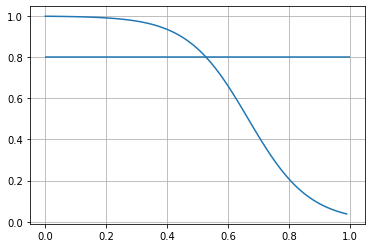

In [458]:
inter = np.arange(0.0, 1.0, 0.01)
ex = 1 + np.exp(10*(inter-np.divide(4,6)))
pl = np.divide(1, ex)

fig, ax = plt.subplots()
ax.plot(inter, pl)
ax.grid()
ax.hlines(y = 0.8, xmin = 0, xmax = 1)
plt.show()

Copyright &copy; 2022 Marina Barsky.